In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
def generate_data(distrib,*args):
    return distrib(*args)
def mean(values, axis=None):
    """Function to use in bootstrap

    Parameters
    ----------
    values : data to average
    axis : axis or axes along which average
    Returns
    ----------
    mean : ndarray
        Average
    """
    if axis==None:
        return np.mean(values)
    else:
        return np.mean(values, axis=axis)
def resampling(values,B):
    """Creates B samples for the bootstrap (with replacements)
    
    Parameters
    ----------
    values : ndarray
        data to use 
    B : int
        number of samples needed
    Returns
    ----------
    x_resampled : ndarray
        array with dim0=B+1, contains the B samples and the original data in 
    the last position of the first axis (x_resampled[-1,:,:])
    
    """
    if B==1:
        return resample(values,replace=True)
    else:
        x_resampled = np.empty((B+1, values.size))
        x_resampled[-1,:] = values
        for i in range(B):
            x_resampled[i,:] = resample(values, replace=True)
        return x_resampled

### Statistics (mean and std) for the means and confidence interval obtained by bootstrap method for 100 different draws

In [5]:
import xarray as xr
import dask.array as da
import dask

In [8]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#client = Client(cluster)
client= Client()
client

Client Scheduler: tcp://127.0.0.1:49366 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [68]:
def bootstrap_delta(b, n, alpha=.05, mean=0., rms=0.1, Nexp=100):
    """
    Parameters
    
    b : int
        number of samples used for the bootstrap
    n : int
        size of the original data
    alpha : float
        confidence interval wanted
    xmean : float
        mean of the distribution
    xrms : float
        standard deviation of the distribution
    Nexp : int
        number of draws
    Returns
    
    out : ndarray
        mean and std average over the bootstrap, mean and std of lower band, mean and std of upper band
    """
    x = np.random.normal(mean, rms, size=(n, Nexp))
    sample_mean = x.mean(axis=0)
    X = xr.DataArray(resampling(x, b), dims=['bsample', 'points', 'experiments'])
    deltastar = (X.mean(dim='points')-sample_mean)
    q = deltastar.quantile([alpha,1-alpha], dim='bsample')
    deltal = q.isel(quantile=0)
    deltau = q.isel(quantile=1)
    ci = [sample_mean-deltal,sample_mean-deltau]
#    return np.hstack([sample_mean.mean(), sample_mean.std(), 
#                      deltal.mean(),deltal.std(), 
#                      deltau.mean(),deltau.std()])
    return np.hstack([deltastar.mean(), deltastar.std(), 
                      ci[0].mean(),ci[0].std(), 
                      ci[1].mean(),ci[1].std()])

### Confidence interval around an average using the bootstrap method, general description (Lecture of MIT : Boostrap confidence intervals,  by Jeremy Orloff and Jonathan Bloom) : 
Let x be the data to average: x = $(x_1,..,x_n)$ following a distribution F, with $n\in \mathbb{N}$ \
Steps of the bootstrap method: \
1) Resampling : Draw B times a sample $x^*$ such as, $x^* = (x_1^*,...,x_n^*)$, from x with replacement (the same value $x_i$ can be drawn several times\
We write $\bar x$ the sample mean and $\bar x^*$ the mean of a bootstrap sample.\
2) Compute the variations to the empirical mean ($\bar x$), $\delta^*$ such as $\delta^* = \bar x^* - \bar x$\
In this step, we use the variations $\delta^*$ to avoid errors due to possible difference between the true mean ,$\mu$ of the "true" distribution and the sample mean around which the $\bar x^*$ will be centered.\
3) Define $\alpha$ the percentile to use for the confidence interval\
4) Compute the confidence interval, CI=$[\bar x - \delta^*_\alpha ; \bar x - \delta^*_{1-\alpha}]$

### Implementation of the bootstrap method for a dataset normally distributed and comparison to the theoritical values 
 We compute the confidence interval (CI) for the mean of a normal distribution using the bootstrap method. Knowing the theoritical values for this distribution we are able to evaluate the efficiency of the bootstrap method for different sample sizes and number of bootstrap.d

In [69]:
bootstrap_delta_delayed = dask.delayed(bootstrap_delta, pure=True)

In [70]:
b = np.arange(10,100,10) # bootstrap
df = np.arange(10,100,10) # degrees of freedom
Nexp = 5000 # number of experiences
xmean = 0. # mean of the distribution
rms = 0.1 # rms of the distribution
alpha = 0.1 # percentile


lazy_data = [bootstrap_delta_delayed(_b, _n, alpha, mean=xmean, rms=rms, Nexp=Nexp) for _b in b for _n in df]
sample = lazy_data[0].compute()
arrays = [da.from_delayed(lazy_value,
                          dtype=sample.dtype,
                          shape=sample.shape)
          for lazy_value in lazy_data]

stack = (da.stack(arrays, axis=0)
         .reshape((len(b),len(df), sample.size))
        )

# HERE
stat_names = ['delta_mean', 'delta_rms', 
         'lower_mean', 'lower_rms', 
         'higher_mean', 'higher_rms']
_ds = (xr.DataArray(stack, dims=['b','df','stats'])
      .assign_coords(stats=stat_names,
                     b=b,
                     df=df)
     )

ds = xr.merge([_ds.sel(stats=s).drop('stats').rename(s) for s in stat_names]).persist()
ds

<xarray.Dataset>
Dimensions:      (b: 9, df: 9)
Coordinates:
  * b            (b) int64 10 20 30 40 50 60 70 80 90
  * df           (df) int64 10 20 30 40 50 60 70 80 90
Data variables:
    delta_mean   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    delta_rms    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_mean   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_rms    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_mean  (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_rms   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>

#### Theoritical confidence interval (CI) for a normal distribution : 
With true mean, $\mu$ = 0. , rms, $\sigma$ = 0.1  and $\alpha$ = 0.1 \
CI = $[C_0;C_1]$=$[\bar x-t_\alpha\frac{\sigma}{\sqrt n},\bar x+t_\alpha\frac{\sigma}{\sqrt n}]$ ; for a 95% CI, $t_{95}$=1.96

In [71]:
from scipy.stats import norm
#xx = norm.pdf(X.mean(axis=1), loc=xmean, scale=xrms/np.sqrt(n))
def get_percentile(alpha, loc, rms, n):
    _p = lambda alpha: norm.ppf(alpha, loc=loc, 
                                scale=rms/np.sqrt(n))
    return _p(alpha), _p(1.-alpha)

th = get_percentile(alpha, xmean, rms, df)
ds['lower_th'] = xr.DataArray(th[0], dims=['df'])
ds['upper_th'] = xr.DataArray(th[1], dims=['df'])

#### Visualization of the mean and rms of the averaged data and CI bounds

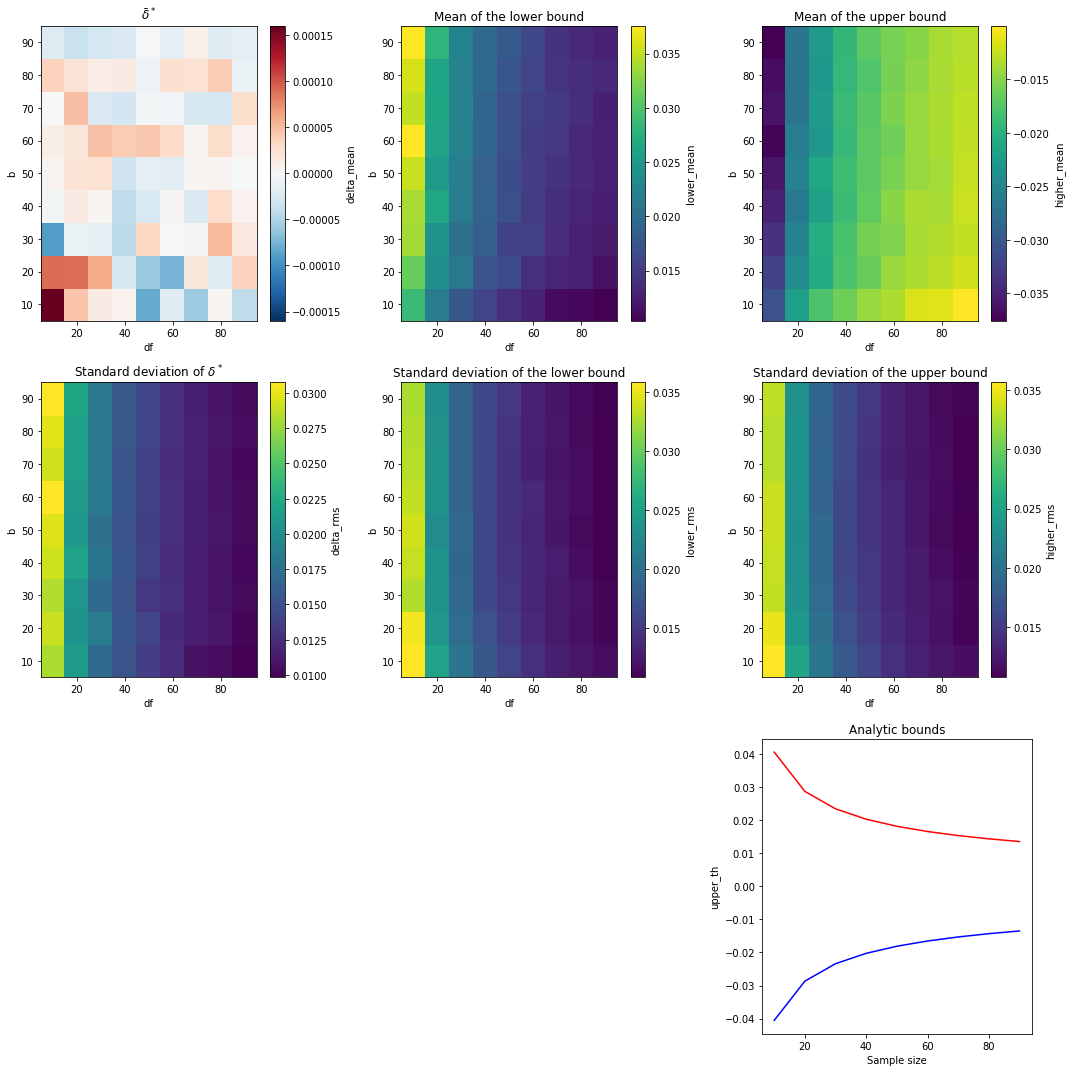

In [82]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,3,1)
ds.delta_mean.plot(ax=ax)
ax.set_title(r'$\bar \delta ^*$')#'Mean of the average')
ax = fig.add_subplot(3,3,4)
ds.delta_rms.plot(ax=ax)
ax.set_title(r'Standard deviation of $\delta^*$')#the average')
ax = fig.add_subplot(3,3,2)
ds.lower_mean.plot(ax=ax)
ax.set_title('Mean of the lower bound')
#ax.scatter(df,bootl,c='r',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,5)
ds.lower_rms.plot(ax=ax)
ax.set_title('Standard deviation of the lower bound')
ax = fig.add_subplot(3,3,3)
ds.higher_mean.plot(ax=ax)
ax.set_title('Mean of the upper bound')
#ax.scatter(df,booth,c='b',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,6)
ds.higher_rms.plot(ax=ax)
ax.set_title('Standard deviation of the upper bound')
ax = fig.add_subplot(3,3,9)
ds.lower_th.plot(c='b',ax=ax)
ds.upper_th.plot(c='r',ax=ax)
ax.set_title('Analytic bounds')
ax.set_xlabel('Sample size')

plt.tight_layout()

#### Normalized confidence interval bounds rms (first line) and mean (second line)
var($\bar x - \delta^*_{0.1}$)/$C_0$ ; $\overline {\bar x - \delta^*_{0.1}}$/$C_0$\
var($\bar x - \delta^*_{0.9}$)/$C_1$ ; $\overline {\bar x - \delta^*_{0.1}}$/$C_1$

Text(0.5, 1.0, 'Normalized upper bound mean')

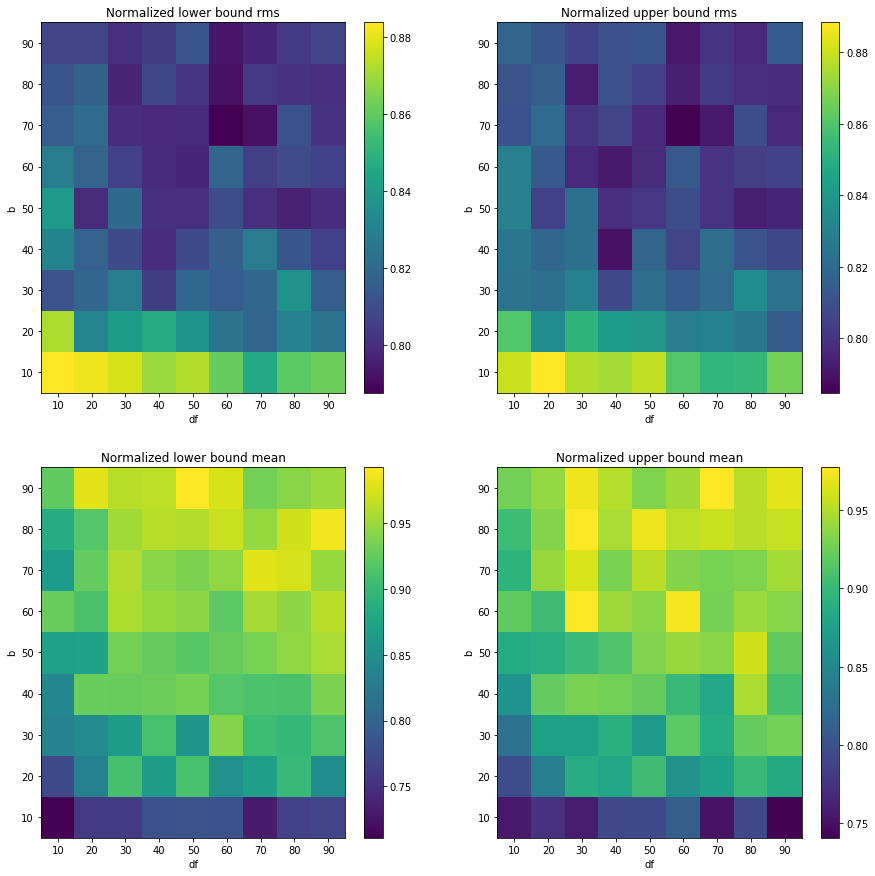

In [76]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
abs(ds['lower_rms']/ds['lower_th']).plot(ax=ax)
ax.set_title('Normalized lower bound rms')
ax = fig.add_subplot(2,2,3)
abs(ds['lower_mean']/ds['lower_th']).plot(ax=ax)
ax.set_title('Normalized lower bound mean')
ax = fig.add_subplot(2,2,2)
abs(ds['higher_rms']/ds['upper_th']).plot(ax=ax)
ax.set_title('Normalized upper bound rms')
ax = fig.add_subplot(2,2,4)
abs(ds['higher_mean']/ds['upper_th']).plot(ax=ax)
ax.set_title('Normalized upper bound mean')

### 2D data:

In [ ]:
def bootstrap(values,B,stats,axis,t,*args_distrib):
    """Boostrap method
    
    Parameters
    ----------
    values : ndarray
        data or None if random generation of data following a specific distribution wanted
    idstri
    args_distrib : 
        args for chosen distribution
    B : int
        number of resampling
    stats : func 
        estimator (function to define)
    axis : int
        axis along which the stat function will be applied
    t : float
        parameter defining the confidence interval
    Returns
    ----------
    x_samples : ndarray
        array containing all the resampled data and the original data
    var : list
        variance computed using bootstrap method
    low : list
        lower bound of the confidence interval
    high : list
        upper bound of the confidence interval
    """
    x = np.random.normal(mean, rms, size=(n, Nexp))
    X = xr.DataArray(resampling(x, b), dims=['bsample', 'points', 'experiments'])
    mean = X.mean(dim='points')
    q = mean.quantile([alpha,1-alpha], dim='bsample')
    lower = q.isel(quantile=0)
    upper = q.isel(quantile=1)
    return np.hstack([mean.mean(), mean.std(), 
                      lower.mean(),lower.std(), 
                      upper.mean(),upper.std()])
    x_samples = resampling(values,B)
    n = stats(x_samples[-1,:,:],axis=axis).size
    means = mean(x_samples,axis+1)
    low = []
    high = []
    val = []
    p = ((1-t)/2) * 100
    p_ = ((1+t)/2) * 100
    for j in range(x_samples.shape[1]):
        _m = means[:,j]
        low.append(np.percentile(_m, p))
        high.append(np.percentile(_m, p_))
        val.append(_m[-1])
    return x_samples,val,low,high #x_samples, 1/B*var, 1/B*tst#1/B*tst

In [5]:
client.close()